In [159]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# read scraped CHA data
with open("data/CHA_rental_data.obj", "rb") as f:       
    d = pickle.load(f)
cha = pd.DataFrame.from_dict(data = d, orient = "index")

In [161]:
# clean CHA data
cols = ['Address','Monthly Rent','Property Type','Bath','Bed',
        'Voucher Necessary','Availability','Contact','URL','Lat','Long']
cha = cha[cols]
cha.Long = -1 * cha.Long

# correct error
cha.loc["4545145", "Long"] = -87.66593 
cha.loc["4545145", "Lat"] = 41.772175

In [162]:
cha.head()

,Address,Monthly Rent,Property Type,Bath,Bed,Voucher Necessary,Availability,Contact,URL,Lat,Long
1288108,"1718 W 66th St 1, Chicago, IL 60636",800,Apt,1.0,2.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.774000,-87.667300
4012748,"6130 S Eberhart Ave 1, Chicago, IL 60637",1200,Apt,2.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.783000,-87.613600
4017021,"4827 S Seeley Ave , Chicago, IL 60609",600,Apt,1.0,1.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.805800,-87.675600
4036551,"828 E 88th Pl 2, Chicago, IL 60619",875,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.734190,-87.603472
4036578,"4620 S Evans Ave 1, Chicago, IL 60653",1150,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.810646,-87.608165


In [163]:
cha.dtypes

Address               object
Monthly Rent           int64
Property Type         object
Bath                 float64
Bed                  float64
Voucher Necessary     object
Availability          object
Contact               object
URL                   object
Lat                  float64
Long                 float64
dtype: object

In [164]:
# convert to GeoDataFrame
cha['Coordinates'] = list(zip(cha.Long, cha.Lat))

In [165]:
cha['Coordinates'] = cha['Coordinates'].apply(Point)

In [166]:
gcha = geopandas.GeoDataFrame(cha, geometry='Coordinates')

In [167]:
# read block group geojson
blocks_full = geopandas.read_file("data/block-groups.geojson")

In [168]:
blocks = blocks_full[['geometry', 'GEOID']]

In [169]:
blocks.head()

,geometry,GEOID
0,"(POLYGON ((-87.655192 41.983802, -87.655914999...",170310306041
1,(POLYGON ((-87.65111443516709 41.9840326124377...,170310306042
2,"(POLYGON ((-87.656031 41.987344, -87.655303 41...",170310306043
3,"(POLYGON ((-87.66006899999999 41.983622, -87.6...",170310307011
4,"(POLYGON ((-87.65454699999999 41.980646, -87.6...",170310307021


In [170]:
cha_with_geoid = geopandas.sjoin(gcha, blocks, how="left", op='intersects')

In [171]:
cha_with_geoid.head()

,Address,Monthly Rent,Property Type,Bath,Bed,Voucher Necessary,Availability,Contact,URL,Lat,Long,Coordinates,index_right,GEOID
1288108,"1718 W 66th St 1, Chicago, IL 60636",800,Apt,1.0,2.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.774000,-87.667300,POINT (-87.6673 41.774),3028,170316712002
4012748,"6130 S Eberhart Ave 1, Chicago, IL 60637",1200,Apt,2.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.783000,-87.613600,POINT (-87.61360000000001 41.783),3375,170314206001
4017021,"4827 S Seeley Ave , Chicago, IL 60609",600,Apt,1.0,1.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.805800,-87.675600,POINT (-87.6756 41.8058),557,170316115001
4036551,"828 E 88th Pl 2, Chicago, IL 60619",875,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.734190,-87.603472,POINT (-87.603472 41.73419),2756,170314408001
4036578,"4620 S Evans Ave 1, Chicago, IL 60653",1150,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.810646,-87.608165,POINT (-87.608165 41.810646),1178,170318436002


In [172]:
shp_filepath = "data/ZillowNeighborhoods-IL.shp"

In [173]:
zillow_neighborhoods = geopandas.read_file(shp_filepath)

In [174]:
zillow_neighborhoods.head()

,State,County,City,Name,RegionID,geometry
0,IL,Cook,Chicago,Wicker Park,7930,POLYGON ((-87.66743176018612 41.90457224446712...
1,IL,Cook,Chicago,Ravenswood,33597,POLYGON ((-87.66746751104743 41.96890188491437...
2,IL,Carroll,Lanark,Lake Carroll,35553,POLYGON ((-89.89474778399995 42.19632197400006...
3,IL,Cook,Chicago,Edgebrook,51847,POLYGON ((-87.76186400199992 42.00841336200006...
4,IL,Cook,Chicago,Clearing (W),137841,POLYGON ((-87.76188485799992 41.78500995800005...


In [175]:
cha_with_geoid.drop('index_right', axis=1, inplace=True)

In [176]:
cha_geoid_zillow = geopandas.sjoin(cha_with_geoid, zillow_neighborhoods, how="left", op='intersects')

In [177]:
cha_geoid_zillow

,Address,Monthly Rent,Property Type,Bath,Bed,Voucher Necessary,Availability,Contact,URL,Lat,Long,Coordinates,GEOID,index_right,State,County,City,Name,RegionID
1288108,"1718 W 66th St 1, Chicago, IL 60636",800,Apt,1.0,2.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.774000,-87.667300,POINT (-87.6673 41.774),170316712002,82.0,IL,Cook,Chicago,West Englewood,269612
4012748,"6130 S Eberhart Ave 1, Chicago, IL 60637",1200,Apt,2.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.783000,-87.613600,POINT (-87.61360000000001 41.783),170314206001,202.0,IL,Cook,Chicago,West Woodlawn,403353
4017021,"4827 S Seeley Ave , Chicago, IL 60609",600,Apt,1.0,1.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.805800,-87.675600,POINT (-87.6756 41.8058),170316115001,143.0,IL,Cook,Chicago,Back of the Yards,403146
4036551,"828 E 88th Pl 2, Chicago, IL 60619",875,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.734190,-87.603472,POINT (-87.603472 41.73419),170314408001,10.0,IL,Cook,Chicago,Burnside,137634
4036578,"4620 S Evans Ave 1, Chicago, IL 60653",1150,Apt,1.0,3.0,Yes,Check Availability,None,http://chicagoha.gosection8.com/Section-8-hous...,41.810646,-87.608165,POINT (-87.608165 41.810646),170318436002,142.0,IL,Cook,Chicago,Bronzeville,403145
4062682,"8200 S Escanaba Ave 1r, Chicago, IL 60617",1000,Duplex,2.0,4.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.746300,-87.554300,POINT (-87.5543 41.7463),170314603024,24.0,IL,Cook,Chicago,South Chicago,140437
4062710,"211 N Laporte Ave 2, Chicago, IL 60644",950,Duplex,1.0,2.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.884900,-87.748800,POINT (-87.7488 41.8849),170312518005,176.0,IL,Cook,Chicago,South Austin,403120
4062715,"525 N Homan Ave , Chicago, IL 60624",1150,Apt,1.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.891100,-87.710900,POINT (-87.7109 41.8911),170318367001,54.0,IL,Cook,Chicago,East Garfield Park,269577
4062722,"1352 W 64th St 2, Chicago, IL 60636",1150,Apt,1.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.777990,-87.658923,POINT (-87.658923 41.77799),170318349002,5.0,IL,Cook,Chicago,Englewood,138261
4062766,"1352 W 64th St 2, Chicago, IL 60636",1150,Apt,1.0,3.0,Yes,Available Now,(773) 961-4367,http://chicagoha.gosection8.com/Section-8-hous...,41.777990,-87.658923,POINT (-87.658923 41.77799),170318349002,5.0,IL,Cook,Chicago,Englewood,138261


In [178]:
### Decided to not include manual cleaning

# Drop rows with false addresses
# cha_geoid_zillow.drop(index = ['4763759','4796475'], inplace=True)

In [179]:
# Fill NA values of Zillow Region
# cha_geoid_zillow.fillna({"State": "IL", "County": "Cook", "City": "Chicago"}, inplace=True)

In [180]:
# unmatches = cha_geoid_zillow[cha_geoid_zillow["index_right"].isna()]

In [181]:
# Manually look up corresponding Zillow Regions on zillow.com  
# values = {'4567448': ['Gresham', '269571'],
#         '4590237': ['Gresham', '269571'],
#         '4618006': ['Cabrini Green', '403302'],
#         '4632177': ['Park Manor', '403356'],
#         '4640435': ['Marquette Park', '403148'],
#         '4646604': ['Rogers Park', '269605'],
#         '4729058': ['Morgan Park', '269595'],
#         '4729219': ['West Town', '269615']}

In [182]:
# for i in unmatches.index:
#    cha_geoid_zillow.loc[i, ["Name", "RegionID"]] = values[i]

In [183]:
cha_geoid_zillow.dropna(axis=0, subset=["index_right"], inplace=True)

In [184]:
len(cha_geoid_zillow)

5266

In [185]:
cha_geoid_zillow.drop('index_right', axis=1, inplace=True)

In [186]:
cha_geoid_zillow.isna().any()

Address              False
Monthly Rent         False
Property Type        False
Bath                 False
Bed                  False
Voucher Necessary    False
Availability         False
Contact               True
URL                  False
Lat                  False
Long                 False
Coordinates          False
GEOID                False
State                False
County               False
City                 False
Name                 False
RegionID             False
dtype: bool

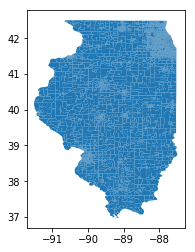

In [187]:
blocks_full.plot()

In [188]:
# count number of properties in each census block group

In [189]:
count_series = cha_geoid_zillow.groupby('GEOID').size()

In [190]:
count_series

GEOID
170310101001     1
170310101002     2
170310102012     7
170310102013     1
170310105012     3
170310106001     3
170310106003     2
170310107011     1
170310107023     2
170310201001     2
170310201002     3
170310204002     1
170310205002     1
170310205003     5
170310205004     1
170310206023     1
170310207023     2
170310208021     1
170310209012     4
170310209013     4
170310301012     1
170310301014     1
170310301021     1
170310301023     1
170310303001     1
170310306013     1
170310307031     1
170310312004     2
170310401002     1
170310403003     1
                ..
170318418002    32
170318421001    10
170318421002     1
170318421003     1
170318421004     6
170318421005     4
170318421006     3
170318424001     4
170318424002    11
170318424003     4
170318425001     6
170318426003     3
170318428001     1
170318428005     1
170318430001    12
170318430002    24
170318431001    12
170318431002     4
170318432001     1
170318433001     1
170318434001     1
170318

In [191]:
new_df = pd.DataFrame()

In [192]:
new_df['GEOID'] = count_series.index

In [193]:
new_df['count_properties'] = count_series.values

In [194]:
new_df

,GEOID,count_properties
0,170310101001,1
1,170310101002,2
2,170310102012,7
3,170310102013,1
4,170310105012,3
5,170310106001,3
6,170310106003,2
7,170310107011,1
8,170310107023,2
9,170310201001,2


In [195]:
city_blocks = geopandas.read_file("Boundaries - Census Blocks - 2010.geojson")

In [196]:
city_blocks['GEOID'] = city_blocks['geoid10'].str.slice(start=0, stop=12)

In [197]:
merged = pd.merge(city_blocks, new_df, how="left")

In [221]:
merged = merged.fillna(0)

In [222]:
merged

,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10,geometry,GEOID,count_properties
0,17,Block 2010,2010,6903002010,170316903002010,690300,031,(POLYGON ((-87.62906799941059 41.7690860000715...,170316903002,12.0
1,17,Block 3007,3007,6809003007,170316809003007,680900,031,(POLYGON ((-87.6341179992764 41.77446599958471...,170316809003,3.0
2,17,Block 3013,3013,6809003013,170316809003013,680900,031,(POLYGON ((-87.63485400018324 41.7726330002261...,170316809003,3.0
3,17,Block 4019,4019,2909004019,170312909004019,290900,031,(POLYGON ((-87.73841099998789 41.8591310003707...,170312909004,27.0
4,17,Block 4016,4016,2925004016,170312925004016,292500,031,(POLYGON ((-87.73217300001724 41.8547640004652...,170312925004,0.0
5,17,Block 4000,4000,2925004000,170312925004000,292500,031,(POLYGON ((-87.72984100036327 41.8588000007334...,170312925004,0.0
6,17,Block 2003,2003,3009002003,170313009002003,300900,031,(POLYGON ((-87.70401800042956 41.8513219998494...,170313009002,1.0
7,17,Block 2002,2002,8407002002,170318407002002,840700,031,(POLYGON ((-87.69811999961215 41.8509509994397...,170318407002,0.0
8,17,Block 3019,3019,8407003019,170318407003019,840700,031,(POLYGON ((-87.69057000011132 41.8528789995538...,170318407003,0.0
9,17,Block 3005,3005,7502003005,170317502003005,750200,031,(POLYGON ((-87.67407699954941 41.6967430002137...,170317502003,0.0


In [223]:
variable = 'count_properties'

In [247]:
vmin, vmax = 0, 48

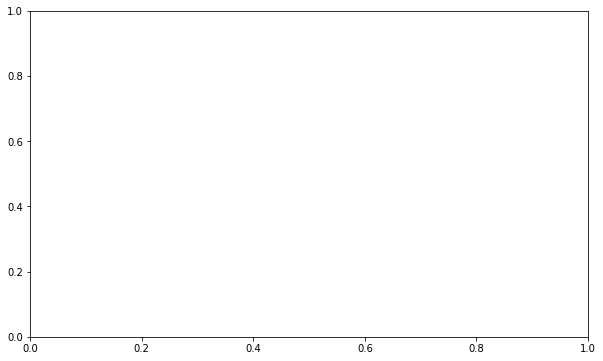

In [224]:
fig, ax = plt.subplots(1, figsize=(10, 6))

In [225]:
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

<Figure size 432x288 with 0 Axes>

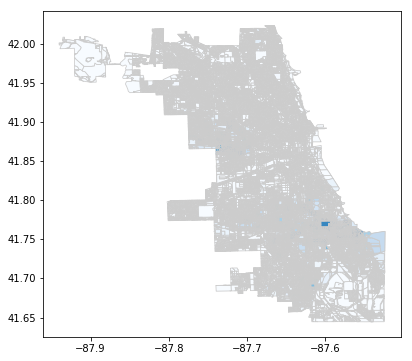

In [226]:
fig

In [227]:
fig.savefig('testmap.png', dpi=300)

In [228]:
merged['count_properties'].describe()

count    46357.000000
mean         2.458572
std          5.064831
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         48.000000
Name: count_properties, dtype: float64

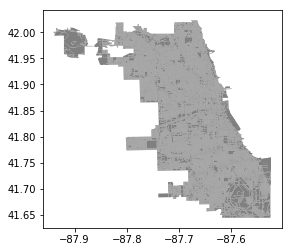

In [211]:
ax = merged.plot(color="grey")

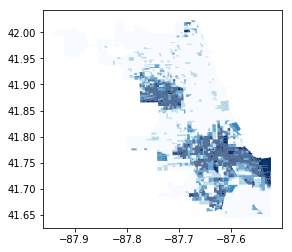

In [252]:
merged.plot(column=variable, cmap='Blues', scheme='Quantiles')

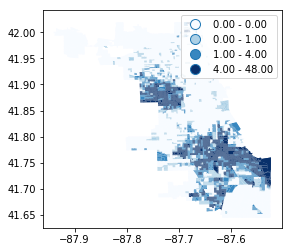

In [230]:
merged.plot(column=variable, cmap='Blues', scheme='Quantiles', legend=True)

In [231]:
#MADE A MAP WOOOOO

In [232]:
#Now to fix the axis and legend

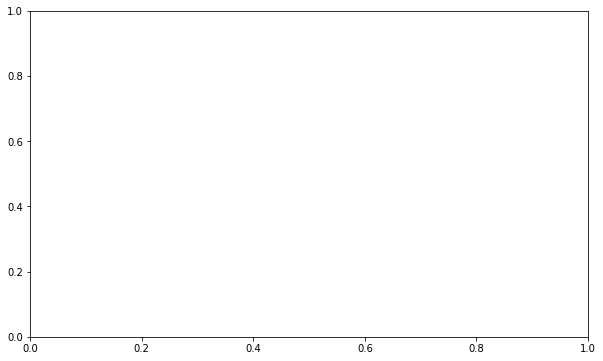

In [253]:
fig, ax = plt.subplots(1, figsize=(10, 6))

In [254]:
merged.plot(column=variable, cmap='Blues', scheme='Quantiles', ax=ax)

<Figure size 432x288 with 0 Axes>

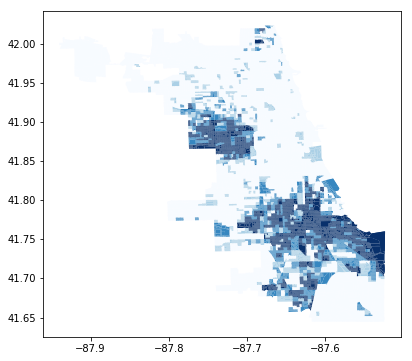

In [255]:
fig

In [256]:
ax.axis('off')

(-87.96092299967849, -87.50283899989881, 41.62534354965313, 42.04207745023128)

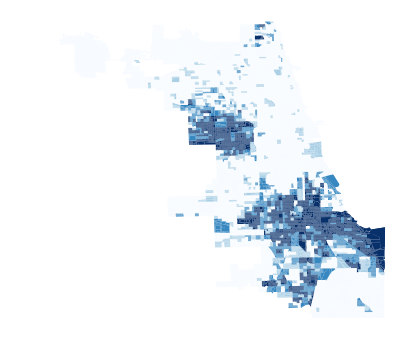

In [257]:
fig

In [258]:
sm = plt.cm.ScalarMappable(cmap= 'Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

In [259]:
sm._A = []

In [260]:
cbar = fig.colorbar(sm)

In [267]:
ax.set_title('Where are CHA Properties Located?', fontdict={'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'Where are CHA Properties Located?')

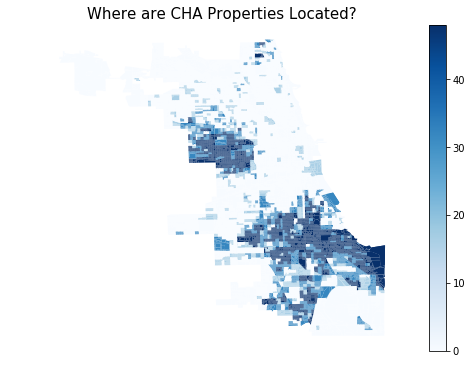

In [268]:
fig

In [269]:
fig.savefig('testmap.png', dpi=300)

In [270]:
#ONE MORE ATTEMPT BEFORE BED

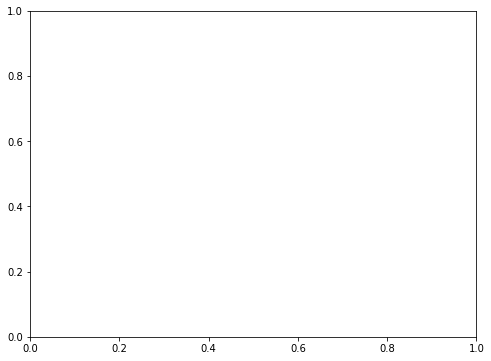

In [273]:
fig, ax = plt.subplots(1, figsize=(8, 6))

In [274]:
merged.plot(column=variable, cmap='Blues', scheme='Quantiles', ax=ax)

<Figure size 432x288 with 0 Axes>

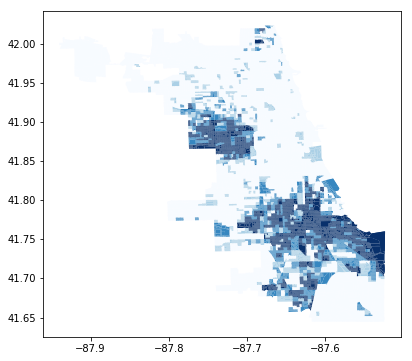

In [275]:
fig

In [276]:
ax.axis('off')

(-87.96092299967849, -87.50283899989881, 41.62534354965313, 42.04207745023128)

In [277]:
sm = plt.cm.ScalarMappable(cmap= 'Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

In [278]:
sm._A = []

In [279]:
cbar = fig.colorbar(sm)

In [280]:
ax.set_title('Where are CHA Properties Located?', fontdict={'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'Where are CHA Properties Located?')

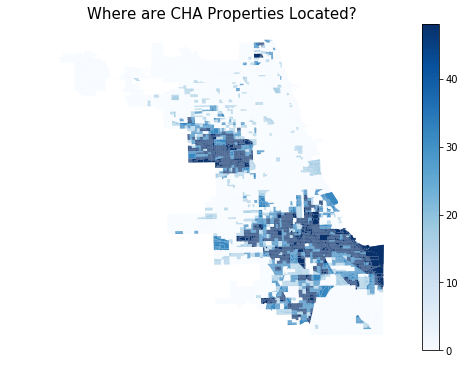

In [281]:
fig

In [282]:
fig.savefig('testmap2.png', dpi=300)